# LAB04 - 2D Convolution

## Part 3 - application on real images

Objectives
- do some padding on real image
- apply some basic filters through convolution on real image:
    - Laplacian,
    - vertical and horizontal details detection,
    - bluring with Gaussian kernels,
    - unsharp masking,
    - convolution with separab le kernels.



## Imported librairies and configurations

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import rcParams
import skimage as sk
from scipy import ndimage
from scipy import signal
import scipy.stats as st
from scipy import fftpack

from sys import path
path.append('../tisLib')
from myTisLib import *


## Global parameters for the lab
|parameter|value|description|
|---|---|---|
|NUM_GRAYS| 256| number of gray levels in a gray image|
|MIN_GRAY| 0| minimum value for the gray level (black pixel) |
|MAX_GRAY| 255| maximum value for the gray level (white pixel) |

In [2]:
NUM_GRAYS=256
MIN_GRAY=0
MAX_GRAY=255

PLANES=["RED", "GREEN", "BLUE", "ALPHA"]
COLORS=['r', 'g', 'b']

# Ex3 - Convolution on real images

## Ex3.1 - Padding real image

- load the image `data/lena.tif` as a gray image in an array `f`,
- display the image and its size,
- save the output to `labo04-ex3.1.png`.


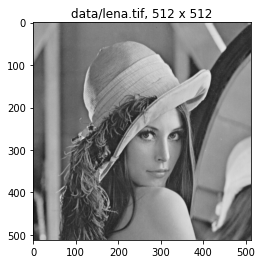

In [3]:
filename='data/lena.tif'
f = plt.imread(filename)
myFancyPlot(f, title="{0}, {1} x {2}".format(filename, f.shape[0], f.shape[1]), saveto="output/labo04-ex3.1.png")



## Ex3.2 - Use the different padding options on lena

- padd the previous array `f` with the 4 padding options for a 129x129 mask,
- display the results,
- add a green rectangle in the original area in the results,
- save the output to `labo04-ex3.2.png`.


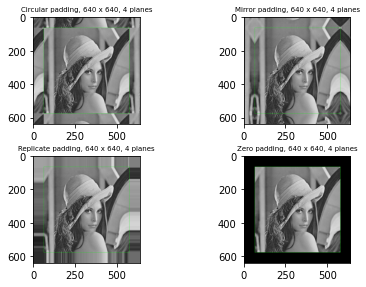

In [4]:
mask = np.zeros((129,129))

a = (np.shape(mask)[0] - 1) // 2
b = (np.shape(mask)[1] - 1) // 2

greenPixel = [0,255,0,255]

zeroPadded = imagePadding(f, mask, "zero")
zeroPadded[a,b:-b] = greenPixel
zeroPadded[-a,b:-b] = greenPixel
zeroPadded[a:-a,b] = greenPixel
zeroPadded[a:-a,-b] = greenPixel

circularPadded = imagePadding(f, mask, "circular")
circularPadded[a,b:-b] = greenPixel
circularPadded[-a,b:-b] = greenPixel
circularPadded[a:-a,b] = greenPixel
circularPadded[a:-a,-b] = greenPixel

mirrorPadded = imagePadding(f, mask, "mirror")
mirrorPadded[a,b:-b] = greenPixel
mirrorPadded[-a,b:-b] = greenPixel
mirrorPadded[a:-a,b] = greenPixel
mirrorPadded[a:-a,-b] = greenPixel

replicatePadded = imagePadding(f, mask, "replicate")
replicatePadded[a,b:-b] = greenPixel
replicatePadded[-a,b:-b] = greenPixel
replicatePadded[a:-a,b] = greenPixel
replicatePadded[a:-a,-b] = greenPixel

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
plt.subplot(2,2,1,)
plt.title("Circular padding, {0} x {1}, {2} planes".format(circularPadded.shape[0], circularPadded.shape[1], circularPadded.shape[2]), fontsize = 7)
plt.imshow(circularPadded)

plt.subplot(2,2,2)
plt.title("Mirror padding, {0} x {1}, {2} planes".format(mirrorPadded.shape[0], mirrorPadded.shape[1], mirrorPadded.shape[2]), fontsize = 7)
plt.imshow(mirrorPadded)

plt.subplot(2,2,3)
plt.title("Replicate padding, {0} x {1}, {2} planes".format(replicatePadded.shape[0], replicatePadded.shape[1], replicatePadded.shape[2]), fontsize = 7)
plt.imshow(replicatePadded)

plt.subplot(2,2,4)
plt.title("Zero padding, {0} x {1}, {2} planes".format(zeroPadded.shape[0], zeroPadded.shape[1], zeroPadded.shape[2]), fontsize = 7)
plt.imshow(zeroPadded)

plt.savefig('output/labo04-ex3.2.png', dpi=300, facecolor="white")


## Ex3.3 - Binarization of 'road.png'

- load the image 'data/road.png' in `f`
- display the image and the 3 planes (red, green, blue),
- save the output to `labo04-ex3.3.png`,
- compute and display the histograms of each channel,
- save the output to `labo04-ex3.3b.png`,
- select the more constrasted  and apply a threshold to binarize the image as `g`,
- display the image `g` ,
- save the output to `labo04-ex3.3c.png`.


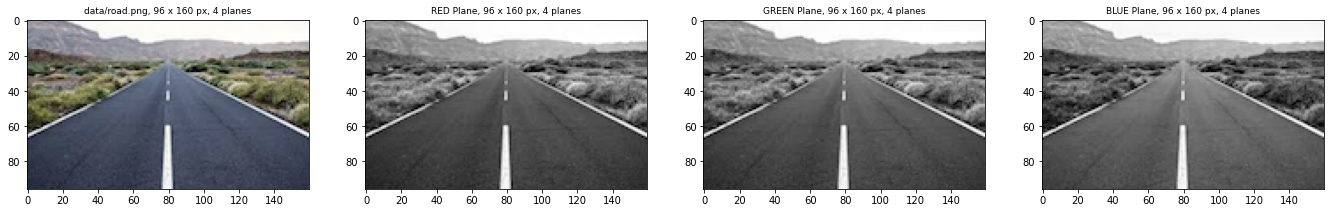

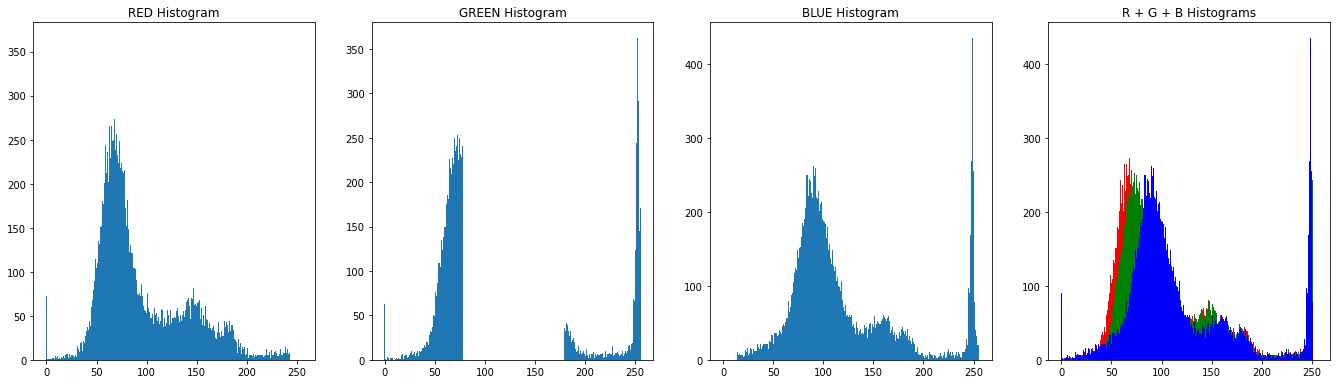

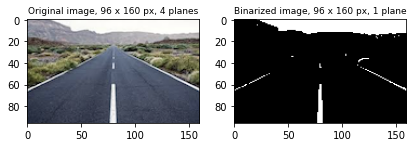

In [5]:
filename='data/road.png'
f = plt.imread(filename)
fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(20.5, 5.5)
plt.subplot(1,4,1)
plt.imshow(f)

plt.title("{0}, {1} x {2} px, {3} planes".format(filename, f.shape[0], f.shape[1], f.shape[2]), fontsize = 9)
for i in range(3):
    plt.subplot(1,4,i+2)
    plt.imshow(f[:,:,i], cmap='gray')
    plt.title("{0} Plane, {1} x {2} px, {3} planes".format(PLANES[i], f.shape[0], f.shape[1], f.shape[2]), fontsize = 9)

plt.savefig('output/labo04-ex3.3.png', dpi=300, facecolor="white")

fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(20.5, 5.5)

histograms = []
for i in range(3):
    histograms.append(np.histogram((f[:,:,i]*MAX_GRAY).astype("uint8"), bins=np.arange(1+NUM_GRAYS))) # (histo, bins)
    plt.subplot(1,4,i+1)
    plt.bar(np.arange(NUM_GRAYS), histograms[i][0])
    plt.title("{0} Histogram".format(PLANES[i]))
    plt.subplot(1,4,4)
    plt.bar(np.arange(NUM_GRAYS), histograms[i][0], color=COLORS[i])

plt.title("R + G + B Histograms")
plt.savefig('output/labo04-ex3.3b.png', dpi=300, facecolor="white")

# Find most contrasted plane
contrasts = []
for i in range(3):
    contrasts.append(computeGrayScaleContrast(f[:,:,i]))

indexMax = np.argmax(contrasts)



# Finding best threshold
order = 10  # polynomial approximation's order
polyApprox = np.polyfit(np.arange(NUM_GRAYS), histograms[indexMax][0], order)
roots = np.roots(np.polyder(polyApprox)) # Gives zeros of derivative of histogram approximation polynomial


# Placing the threshold automaticaly in the interval ]150, 200[
threshold = int(roots[np.argwhere(np.logical_and(roots > 150, roots < 200))[0]])
lut=np.ones(256, dtype='uint8' ) * MAX_GRAY
lut[0:threshold] = 0
g = applyLUT((f[:,:,indexMax]*MAX_GRAY).astype("uint8"), lut)

fig, axes = plt.subplots()
fig.tight_layout()

plt.subplot(1,2,1)
plt.imshow(f)
plt.title("Original image, {0} x {1} px, {2} planes".format(f.shape[0], f.shape[1], f.shape[2]), fontsize = 9)

plt.subplot(1,2,2)
plt.imshow(g, cmap="gray")
plt.title("Binarized image, {0} x {1} px, 1 plane".format(f.shape[0], f.shape[1]), fontsize = 9)
plt.savefig('output/labo04-ex3.3c.png', dpi=300, facecolor="white")

## Ex3.4 - Laplacian mask on `road.png` binarized

- apply a 2D convolution with a laplacian 3x3 mask,
- display the result,
- save the output to `labo04-ex3.4.png`.


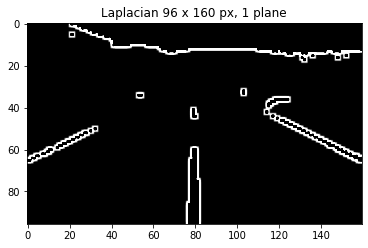

In [6]:
laplacianMask=np.array( [[1,1,1],[1,-8,1],[1,1,1]]); 

laplacian = conv2D(g, laplacianMask, norm=False)

myFancyPlot(laplacian, title="Laplacian {0} x {1} px, 1 plane".format(f.shape[0], f.shape[1]), cmap="gray", saveto="output/labo04-ex3.4.png")


## Ex3.5 - vertical detector mask on `road.png` binarized

- apply a 2D convolution for vertical details detection with 3x3 mask,
- `verticalDetector` is a 3x3 matrix [[1,-2,1],[1,-2,1],[1,-2,1]],
- display the result,
- save the output to `labo04-ex3.5.png`.


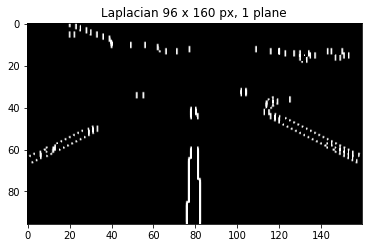

In [7]:
verticalDetector=np.array( [[1,-2,1],[1,-2,1],[1,-2,1]]); 

verticalDetectorConv = conv2D(g, verticalDetector, norm=False)

myFancyPlot(verticalDetectorConv, title="Laplacian {0} x {1} px, 1 plane".format(f.shape[0], f.shape[1]), cmap="gray", saveto="output/labo04-ex3.5.png")


## Ex3.6 - horizontal detector mask on `road.png` binarized

- apply a 2D convolution for horizontal details detection with 3x3 mask,
- `horizontalDetector` is a 3x3 matrix [[1,1,1],[-2,-2,-2],[1,1,1]],
- display the result,
- save the output to `labo04-ex3.6.png`.


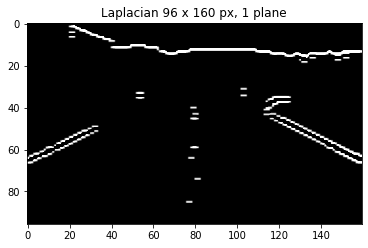

In [8]:
horizontalDetector=np.array( [[1,1,1],[-2,-2,-2],[1,1,1]]); 

horizontalDetectorConv = conv2D(g, horizontalDetector, norm=False)

myFancyPlot(horizontalDetectorConv, title="Laplacian {0} x {1} px, 1 plane".format(f.shape[0], f.shape[1]), cmap="gray", saveto="output/labo04-ex3.6.png")

## Ex3.7 - Bluring `lena` with Gaussian kernels

- apply a 2D convolution for bluring with mask,
- `bluringMask` is a NxN matrix filled with a 2D Gaussian,
- blur the image with the following masks:
    - N=5, sigma=1,
    - N=11, sigma=1,
    - N=19, sigma=1,
- display the results,
- save the output to `labo04-ex3.7.png`.


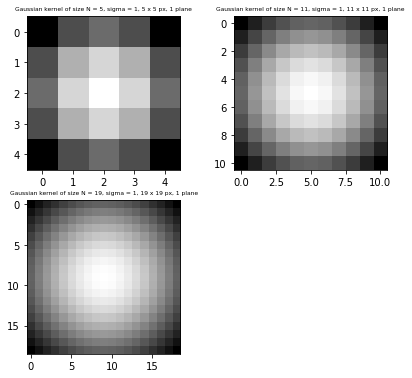

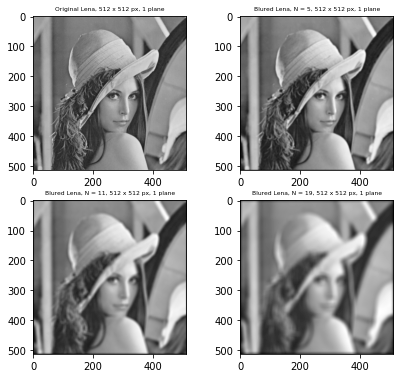

In [9]:
filename='data/lena.tif'
lena = plt.imread(filename)[:,:,0]  # keep only first plane

bluringMasksParam = [[5,1], [11, 1], [19, 1]] # [N, sigma]
bluringKernels = []
bluredLenas = []


fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(6, 5.5)

for idx, maskParam in enumerate(bluringMasksParam):
    bluringKernels.append(gaussianKernel(maskParam[0], maskParam[1]))
    plt.subplot(2,2,idx+1)
    plt.imshow(bluringKernels[idx], cmap="gray")
    plt.title("Gaussian kernel of size N = {0}, sigma = {1}, {2} x {3} px, 1 plane".format(maskParam[0], maskParam[1], bluringKernels[idx].shape[0], bluringKernels[idx].shape[1]), fontsize = 6)

    bluredLenas.append(imageNormalize(conv2D(lena, bluringKernels[idx])))

plt.savefig('output/labo04-ex3.7-kernels.png', dpi=300, facecolor="white")


fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(6, 5.5)

plt.subplot(2,2,1)
plt.imshow(lena, cmap="gray", vmin=0, vmax=255)
plt.title("Original Lena, {0} x {1} px, 1 plane".format(lena.shape[0], lena.shape[1]), fontsize = 6)

for idx,bluredLena in enumerate(bluredLenas):
    plt.subplot(2,2,idx+2)
    plt.imshow(bluredLena, cmap="gray", vmin=0, vmax=1)
    plt.title("Blured Lena, N = {0}, {1} x {2} px, 1 plane".format(bluringMasksParam[idx][0], bluredLena.shape[0], bluredLena.shape[1]), fontsize = 6)

plt.savefig('output/labo04-ex3.7.png', dpi=300, facecolor="white")
    


## Ex3.8 - Unsharp masking on lena

- apply a 2D convolution on `f` for unsharp masking with 3x3 mask and store the result in an array `g`,
- `unsharpMask` is a 3x3 matrix [[1,-4,1],[-4,26,-4],[1,-4,1]],
- display the results `f`, `g`, `f-g`,
- save the output to `labo04-ex3.8.png`.

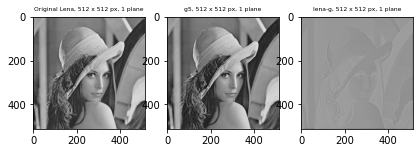

In [10]:
unsharpMask=np.array( [[1,-4,1],[-4,26,-4],[1,-4,1]], dtype='int8'); 

g = imageNormalize(conv2D(lena, unsharpMask))

fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(6, 5.5)

plt.subplot(1,3,1)
plt.imshow(lena, cmap="gray", vmin=0, vmax=255)
plt.title("Original Lena, {0} x {1} px, 1 plane".format(lena.shape[0], lena.shape[1]), fontsize = 6)

plt.subplot(1,3,2)
plt.imshow(g, cmap="gray", vmin=0, vmax=255)
plt.title("g5, {0} x {1} px, 1 plane".format(lena.shape[0], lena.shape[1]), fontsize = 6)

plt.subplot(1,3,3)
plt.imshow(lena-g, cmap="gray")
plt.title("lena-g, {0} x {1} px, 1 plane".format(lena.shape[0], lena.shape[1]), fontsize = 6)

plt.savefig('output/labo04-ex3.8.png', dpi=300, facecolor="white")


## Ex3.9 - Gaussian blur with separable kernel

### Ex 3.9a - Gaussian blur with a 3x3 kernel

- apply a 2D convolution bluring 3x3 maks on `f` and store the result in an array `g1`,
- `bluringMask` is a 3x3 matrix [[1,2,1],[2,4,2],[1,2,1]],


In [11]:
bluringMask=np.array( [[1,2,1],[2,4,2],[1,2,1]]); 

g1 = imageNormalize(conv2D(lena, bluringMask))


### Ex 3.9b - Gaussian blur with a 3x3 separable kernel

- apply a 2D convolution 3x1 mask `m1` on `f` and store the result in an array `g2`,
- `m1` is a 3x1 matrix [[1],[2],[1]],
- apply a 2D convolution 1x3 mask `m2` on `g2` and store the result in an array `g3`,
- `m2` is a 1x3 matrix [[1,2,1]],
- compare `g1` and `g3`,
- display the results `f`, `g1`,`g3` and `g3-g1`,
- save the output to `labo04-ex3.9.png`.

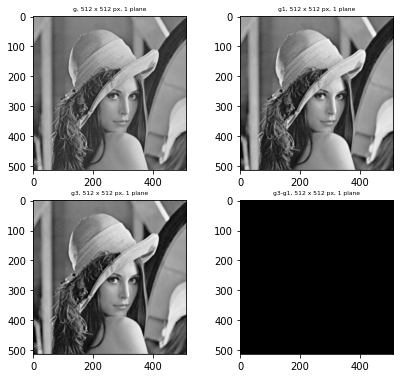

In [12]:
m1=np.array( [[1],[2],[1]]); 
m2=np.array( [[1,2,1]]); 

g2 = conv2D(lena, m1)
g3 = imageNormalize(conv2D(g2, m2))

fig, axes = plt.subplots()
fig.tight_layout()
fig.set_size_inches(6, 5.5)

plt.subplot(2,2,1)
plt.imshow(lena, cmap="gray", vmin=0, vmax=255)
plt.title("g, {0} x {1} px, 1 plane".format(lena.shape[0], lena.shape[1]), fontsize = 6)

plt.subplot(2,2,2)
plt.imshow(g1, cmap="gray", vmin=0, vmax=255)
plt.title("g1, {0} x {1} px, 1 plane".format(g1.shape[0], g1.shape[1]), fontsize = 6)

plt.subplot(2,2,3)
plt.imshow(g3, cmap="gray", vmin=0, vmax=255)
plt.title("g3, {0} x {1} px, 1 plane".format(g3.shape[0], g3.shape[1]), fontsize = 6)

plt.subplot(2,2,4)
plt.imshow(g3 - g1, cmap="gray", vmin=0, vmax=255)
plt.title("g3-g1, {0} x {1} px, 1 plane".format(g3.shape[0], g3.shape[1]), fontsize = 6)

plt.savefig('output/labo04-ex3.9.png', dpi=300, facecolor="white")